In [4]:
"""
필요한 모듈 및 프레임워크를 잘 생각하고 넣자
"""
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np
import pandas as pd 
import os, re

In [5]:
import os
import sys
from keras.preprocessing import image
import numpy as np
import re
from PIL import Image

current_path = os.path.abspath('')
image_path = os.path.join(current_path, "test_img")
input_img_path = os.path.join(current_path, "input_img")
target_img_path = os.path.join(current_path, "target_img")


"""
이미지를 재단하는 함수
입력용 회색이미지, 출력용 색상이미지 재단
"""
def crop_img(image_path):
    
    
    files = os.listdir(image_path)
    select = re.compile("([a-zA-Z0-9_\s\.]+(?=\_pic))")   
   
    for file in files:
        if select.match(str(file)) != None:
            name = str(file)
            os.chdir(image_path)
            img = Image.open(file)

            img = img.crop([136, 112, 917, 823])

            os.chdir(input_img_path)
            img.save(name, "PNG")
            os.chdir('..')
            
        else:
            name = str(file)
            os.chdir(image_path)
            img = Image.open(file)

            img = img.crop([136, 112, 917, 823])

            os.chdir(target_img_path)
            img.save(name, "PNG")
            os.chdir('..')

crop_img(image_path)

In [12]:
"""
전처리 후 npy파일로 저장하기위한 코드
일단 사이즈는 강제로 256,256으로 변환시키는 방식
각 이미지를 일차원 배열로 생성
사용시에는 인덱스에 맞게 꺼내서 사용할 예정
"""

current_path = os.path.abspath('')
input_img_path = os.path.join(current_path,"input_img")
target_img_path = os.path.join(current_path,"target_img")
input_files = os.listdir(input_img_path)
target_files = os.listdir(target_img_path)
datasets = []
i = 0
test_data = np.array([])
for input_file, target_file in zip(input_files, target_files):
    dataset= []
    plus_input = []
    mul_input = []
    input_pro = []
    name = str(input_file)
    #레이놀즈 수 파일 이름에서 추출
    R = float(name[5]+"."+name[6]+name[7])*10**int(name[8])/(1.3*(10**6))
    #인풋 이미지 파일 경로로 들어가서 인풋 이미지 전처리 과정
    os.chdir(input_img_path)
    input_img = Image.open(input_file)
    #이미지 리사이징
    input_img = input_img.resize((256, 256))
    #이미지 nunpy배열로 변환
    input_img_tensor = img_to_array(input_img)
    input_img_tensor = input_img_tensor.reshape(196608).astype('float64')/ 255
    #타겟 이미지 파일 경로로 들어가서 전처리 과정
    os.chdir(target_img_path)
    target_img = Image.open(target_file)
    target_img = target_img.resize((256,256))
    #타겟 이미지는 1차원 배열로 생성
    target_img_tensor = img_to_array(target_img)
    target_img_tensor = target_img_tensor.reshape(196608).astype('float64')/ 255
    plus_input = (input_img_tensor +R)/2
    dataset = np.concatenate((input_img_tensor,plus_input), axis = 0)
    dataset = np.concatenate((dataset,target_img_tensor), axis = 0)
    datasets.insert(i,dataset)
    i += 1
    os.chdir('..')
datasets = np.array(datasets)
#[:,:196608]인풋 이미지,[:,196608:393216]레이놀즈수,[:,393216:]타겟 이미지
np.save("test.npy", datasets)
print(datasets.shape)

(1170, 589824)


In [13]:

dataset = np.load('test.npy', allow_pickle=True)
X = dataset[:,196608:393216]
Y = dataset[:,393216:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =1)
X_test, X_val,Y_test, Y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=1)
X_train = X_train.reshape(X_train.shape[0], 256,256,3)
X_test = X_test.reshape(X_test.shape[0], 256,256,3)
X_val = X_val.reshape(X_val.shape[0], 256,256,3)
Y_train = Y_train.reshape(Y_train.shape[0], 256,256,3)
Y_test = Y_test.reshape(Y_test.shape[0], 256,256,3)
Y_val = Y_val.reshape(Y_val.shape[0], 256,256,3)


In [ ]:
"""
VGG16과 u-net의 조합을 해볼 생각이다.
"""
input_e = tf.keras.Input(shape=(256,256,3))

block1_conv1 = layers.Conv2D(64, 3, activation='relu', padding = 'same')(input_e)
block1_conv2 = layers.Conv2D(64, 3, activation='relu', padding = 'same')(block1_conv1)
block1_pool = layers.MaxPooling2D(2)(block1_conv2)
        
block2_conv1 = layers.Conv2D(128, 3, activation='relu', padding = 'same')(block1_pool)
block2_conv2 = layers.Conv2D(128, 3, activation='relu', padding = 'same')(block2_conv1)
block2_pool = layers.MaxPooling2D(2)(block2_conv2)

block3_conv1 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block2_pool)
block3_conv2 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block3_conv1)
block3_conv3 = layers.Conv2D(256, 3, activation='relu', padding = 'same')(block3_conv2)
block3_pool = layers.MaxPooling2D(2)(block3_conv3)

block4_conv1 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block3_pool)
block4_conv2 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_conv1)
block4_conv3 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_conv2)
block4_pool = layers.MaxPooling2D(2)(block4_conv3)

block5_conv1 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block4_pool)
block5_conv2 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block5_conv1)
block5_conv3 = layers.Conv2D(512, 3, activation='relu', padding = 'same')(block5_conv2)
block5_pool = layers.MaxPooling2D(2)(block5_conv3)
"""
여기까지가 VGG16을 구현한 장소
"""
block6_convt1 = layers.Conv2DTranspose(512, 3, activation='relu', padding='same')(block5_pool)
block6_upsamp = layers.UpSampling2D(2)(block6_convt1)
block6_skipcon = layers.Concatenate(axis=3)([block4_pool, block6_upsamp])
block6_convt2 = layers.Conv2D(512, 3, activation = 'relu', padding='same')(block6_skipcon)

block7_convt1 = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(block6_convt2)
block7_upsamp = layers.UpSampling2D(2)(block7_convt1)
block7_skipcon = layers.Concatenate(axis=3)([block3_pool, block7_upsamp])
block7_convt2 = layers.Conv2D(256, 3, activation = 'relu', padding='same')(block7_skipcon)

block8_convt1 = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(block7_convt2)
block8_upsamp = layers.UpSampling2D(2)(block8_convt1)
block8_skipcon = layers.Concatenate(axis=3)([block2_pool, block8_upsamp])
block8_convt2 = layers.Conv2D(128, 3, activation = 'relu', padding='same')(block8_skipcon)

block9_convt1 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(block8_convt2)
block9_upsamp = layers.UpSampling2D(2)(block9_convt1)
block9_skipcon = layers.Concatenate(axis=3)([block1_pool, block9_upsamp])
block9_convt2 = layers.Conv2D(64, 3, activation = 'relu', padding='same')(block9_skipcon)

block10_convt1 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(block9_convt2)
block10_upsamp = layers.UpSampling2D(2)(block10_convt1)

output_d = layers.Conv2DTranspose(3, 3, activation='relu', padding='same')(block10_upsamp)

model = keras.Model(input_e, output_d, name = 'unet-VGG16')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = model.fit(X_train,Y_train,epochs=500, validation_data=(X_val, Y_val), batch_size=10)

#hist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32)

model.summary()
model.save('test_model_unet_VGG.h5')

Epoch 1/500
94/94 [==============================] - 23s 234ms/step - loss: 0.1920 - mae: 0.2043 - val_loss: 0.0275 - val_mae: 0.0759
Epoch 2/500
94/94 [==============================] - 22s 238ms/step - loss: 0.0284 - mae: 0.0817 - val_loss: 0.0261 - val_mae: 0.0766
Epoch 3/500
94/94 [==============================] - 21s 226ms/step - loss: 0.0271 - mae: 0.0794 - val_loss: 0.0253 - val_mae: 0.0744
Epoch 4/500
94/94 [==============================] - 22s 232ms/step - loss: 0.0264 - mae: 0.0786 - val_loss: 0.0257 - val_mae: 0.0802
Epoch 5/500
94/94 [==============================] - 21s 225ms/step - loss: 0.0259 - mae: 0.0776 - val_loss: 0.0247 - val_mae: 0.0736
Epoch 6/500
94/94 [==============================] - 21s 225ms/step - loss: 0.0258 - mae: 0.0772 - val_loss: 0.0247 - val_mae: 0.0724
Epoch 7/500
94/94 [==============================] - 21s 228ms/step - loss: 0.0254 - mae: 0.0763 - val_loss: 0.0242 - val_mae: 0.0724
Epoch 8/500
94/94 [==============================] - 22s 231ms

(256, 256, 3)
(256, 256, 3)


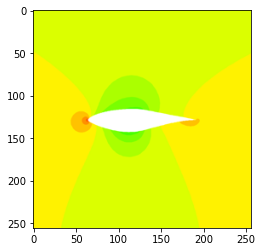

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[53]
prediction = Y_prediction[53]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()

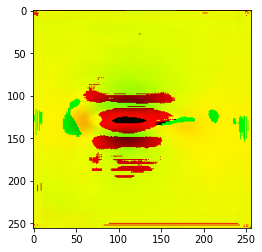

In [16]:
plt.imshow(predi_img)